In [1]:
import os

import torch
import numpy as np
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader

from neulight.dataset.free_viewpoint import FreeViewpointDataset
from neulight.model.neus import NeuSLightningModel
from neulight.utils.files import read_file
from neulight.visualization.visualize_rays import visualize_rays

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


## Read Config

In [2]:
config = read_file("../config/neus.yaml")

## Sample a batch of rays from the training dataset

In [3]:
dtype = torch.float32
device = torch.cuda.current_device()
batch_size = 4
num_workers = 2
free_viewpoint_scene_path = "../data/neulight/Salon2"
num_rays_per_image = 1024

In [4]:
free_viewpoint_train_dataset = FreeViewpointDataset(
    scene_path=free_viewpoint_scene_path,
    dataset_type="train",
    num_rays_per_image=num_rays_per_image,
)
free_viewpoint_train_dataloader = DataLoader(
    free_viewpoint_train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=free_viewpoint_train_dataset.collate_fn,
    num_workers=num_workers,
    persistent_workers=True,
)

In [5]:
batch = free_viewpoint_train_dataset.move_batch_to(
    next(iter(free_viewpoint_train_dataloader)),
    device=device,
    dtype=dtype,
)

In [6]:
image = visualize_rays(
    batch["inputs"]["rays"],
    batch["labels"]["colors"],
    interactive=False,
)

FEngine (64 bits) created at 0x563a572e9770 (threading is enabled)
EGL(1.5)
OpenGL(4.1)


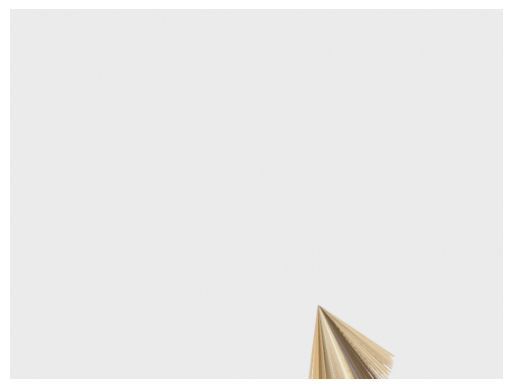

In [7]:
plt.imshow(image)
plt.axis("off")
plt.show()

In [ ]:
batch["inputs"]["rays"][:, 0, :]

tensor([[-15.6208,   0.0741,  12.9548,   0.7402,   0.6116,  -0.2794],
        [-14.9982,  -5.6808,  12.3105,   0.5209,  -0.8208,  -0.2345],
        [-12.8512,   1.2058,   5.3784,   0.6429,   0.3217,  -0.6952],
        [ -5.8567,   2.0850,  11.0758,   0.7584,  -0.6005,  -0.2534]],
       device='cuda:0')

## Initialize the model

In [9]:
neus_model = NeuSLightningModel(config["model"]).to(device)

In [10]:
batch["predicts"] = neus_model(batch["inputs"])

In [11]:
from neulight.utils.torch_numpy import detect_nan

In [12]:
detect_nan(batch["predicts"]["colors"], "colors")

In [13]:
loss = neus_model.loss(batch["predicts"]["colors"], batch["labels"]["colors"])

/home/mukaiy/miniforge3/envs/neulight/lib/python3.10/site-packages/torch/autograd/graph.py:823: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:180.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


In [14]:
loss

tensor(2.2584, device='cuda:0', grad_fn=<AddBackward0>)

In [15]:
loss.backward()